In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import legwork

from matplotlib.ticker import FixedLocator
from matplotlib.lines import Line2D

import os

import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw

import bootstrap as boots

%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [2]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2),
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../../simulation/data/simulation/"

total_DCOs_in_MW = np.load("../../simulation/data/total_DCO_in_MW.npy")

detections = np.load("../../simulation/data/detections_4yr.npy")
detections_10yr = np.load("../../simulation/data/detections_10yr.npy")

In [3]:
""" helper function for setting log spaced ticks """
def get_log_ticks(min_log, max_log):
    
    bottom = np.floor(min_log).astype(int)
    top = np.ceil(max_log).astype(int)
    
    ticks = []
    
    for i in range(bottom, top + 1):
        for j in range(2, 10):
            log_tick = np.log10(j * 10**(i))
            if log_tick > bottom and log_tick < top:
                ticks.append(log_tick)
                
    return ticks

Plotting mass for Fiducial
	Fraction of DCOs with 1 in mass gap: 0.55
Plotting mass for Fryer rapid SN remnant mass prescription
	Fraction of DCOs with 1 in mass gap: 0.00


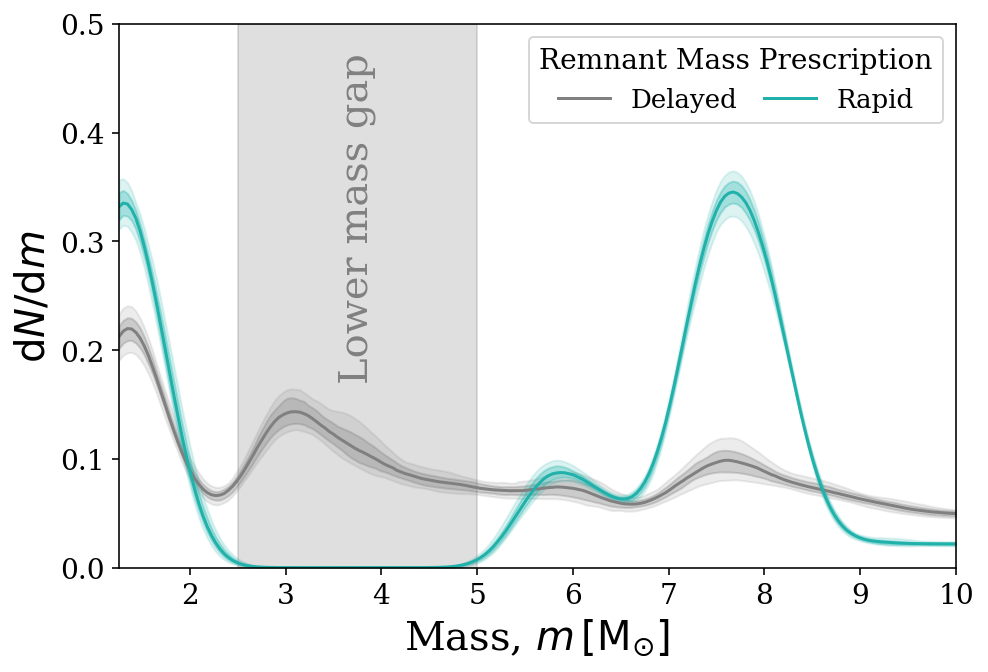

In [58]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
for model, style in [(0, "--"), (11, "-")]:
    bootstraps = 200
        
    mass = np.array([])
    weights = np.array([])
    seeds = np.array([])
    
    fraction_one_in_gap = np.zeros(len(dco_types))

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            something_in_mass_gap = np.logical_or(np.logical_and(data["m_1"] >= 2.5, data["m_1"] <= 5.0),
                                                  np.logical_and(data["m_2"] >= 2.5, data["m_2"] <= 5.0))
            
            fraction_one_in_gap[i] = np.sum(data["weight"][something_in_mass_gap]) / np.sum(data["weight"])
            
            mass = np.concatenate((mass, data["m_1"], data["m_2"]))
            weights = np.concatenate((weights, new_weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"], -1 * data["seed"]))
    
    overall_detected_fraction_in_gap = np.sum(fraction_one_in_gap * detections[:, 0].mean(axis=1)
                                              / detections[:, 0].mean(axis=1).sum())
    
    bw_adjust = 0.4

    # plot the distance distribution
    print("Plotting mass for", variations[model]["long"])
    print("\tFraction of DCOs with 1 in mass gap: {:1.2f}".format(overall_detected_fraction_in_gap))
    ax = boots.bootstrapped_kde(mass, weights, seeds, bw_adjust=bw_adjust,
                                ax=ax, color=variations[model]["colour"], label="Delayed" if model == 0 else "Rapid",
                                bootstraps=bootstraps, lower_bound=0.0, x_min=1.26, x_max=10)
            
ax.axvspan(2.5, 5.0, color="grey", alpha=0.25)
ax.annotate("Lower mass gap", xy=(3.75, 0.17), color="grey", rotation=90, ha="center", va="bottom", fontsize=fs)

ax.set_xlabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_xlim(1.26, 10)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m$")

leg = ax.legend(loc='upper right', fontsize=0.65 * fs, ncol=2, columnspacing=1, title="Remnant Mass Prescription")
leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0, 0.5)

plt.savefig("../figures/lower_mass_gap_rapid_variation_detection_weighted.pdf", format="pdf", bbox_inches="tight")

plt.show()

Plotting mass for Fiducial
Plotting mass for Wolf-Rayet wind factor $f_{\rm WR} = 0.1$
Plotting mass for Wolf-Rayet wind factor $f_{\rm WR} = 5.0$


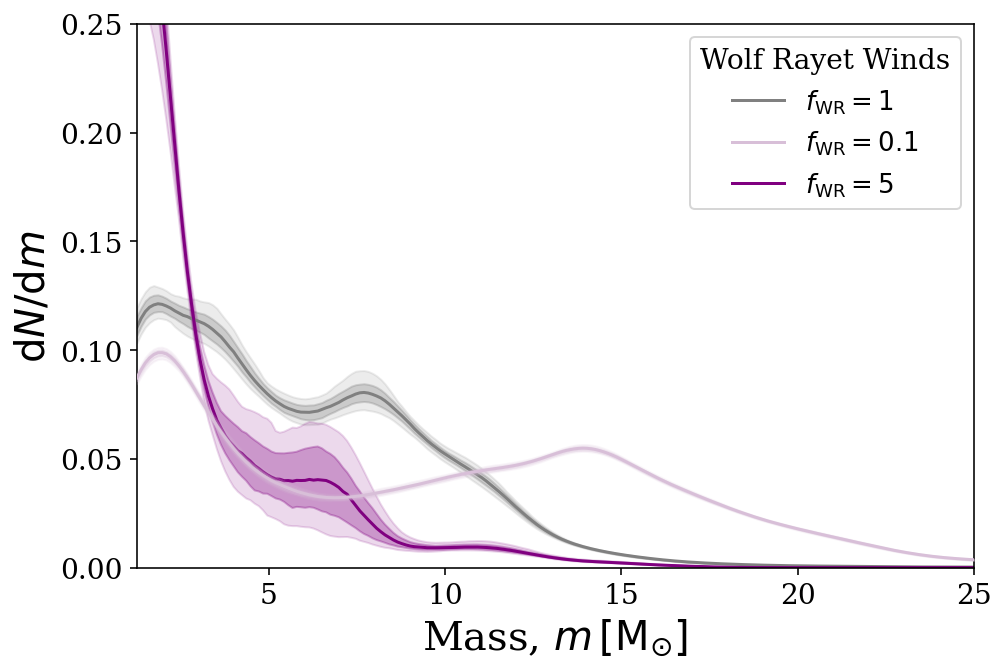

In [194]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
for model, label in [(0, r"$f_{\rm WR} = 1$"), (18, r"$f_{\rm WR} = 0.1$"), (19, r"$f_{\rm WR} = 5$")]:
    bootstraps = 200
        
    mass = np.array([])
    weights = np.array([])
    seeds = np.array([])

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            mass = np.concatenate((mass, data["m_1"], data["m_2"]))
            weights = np.concatenate((weights, new_weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"], -1 * data["seed"]))
    
    # plot the distance distribution
    print("Plotting mass for", variations[model]["long"])
    ax = boots.bootstrapped_kde(mass, weights, seeds,
                                ax=ax, color=variations[model]["colour"], label=label,
                                bootstraps=bootstraps, lower_bound=0.0, x_min=1.26, x_max=25, zorder=100 if model == 18 else None)

ax.set_xlabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_xlim(1.26, 25)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m$")

leg = ax.legend(loc='upper right', fontsize=0.65 * fs, title="Wolf Rayet Winds")
leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0, 0.25)

plt.savefig("../figures/wr_wind_mass_variations.pdf", format="pdf", bbox_inches="tight")

plt.show()

Plotting eccentricity for BHBH
Plotting eccentricity for BHNS
Plotting eccentricity for NSNS
Plotting eccentricity for BHBH
Plotting eccentricity for BHNS
Plotting eccentricity for NSNS


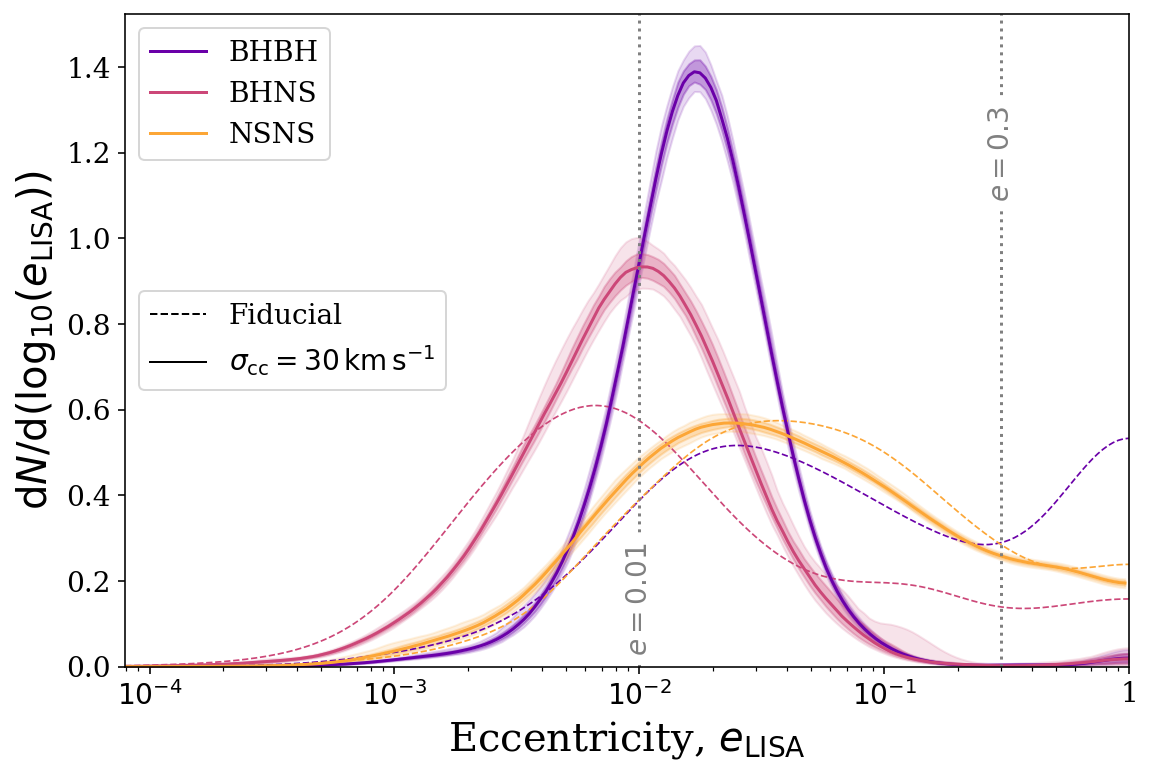

In [118]:
fig, ax = plt.subplots(figsize=(9, 6))
lw = 4
    
for model, style in [(0, "--"), (16, "-")]:
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 200

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()

        # plot the distance distribution
        print("Plotting eccentricity for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(np.log10(data["e_LISA"]), data["weight"], data["seed"], ax=ax, color=dco_colours[dco_type],
                                        label=dco_type, bootstraps=bootstraps, upper_bound=0.0, bw_adjust=1.5)
        else:
            sorted_order = np.argsort(data["seed"])
            sorted_seeds = data["seed"][sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(np.log10(data["e_LISA"][inds]), weights=data["weight"][inds] * counts, upper_bound=0.0, bw_adjust=1.5),
                    color=dco_colours[dco_type], linestyle=style, lw=0.85)

ax.set_xlabel(r"Eccentricity, $e_{\rm LISA}$")
ax.set_xlim(-4.1, 0)
ax.set_xticks([-4, -3, -2, -1, 0])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", "1"])
ax.xaxis.set_minor_locator(FixedLocator(get_log_ticks(*ax.get_xlim())))
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (e_{\rm LISA}))$")


first_legend = plt.legend(loc='upper left', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Fiducial", r"$\sigma_{\rm cc} = 30 \, \rm{km \, s^{-1}}$"],
          loc='center left', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

for e in [0.01, 0.3]:
    ax.axvline(np.log10(e), color="grey", linestyle="dotted")
    ax.annotate(r"$e = {{{}}}$".format(e), xy=(np.log10(e), 0.04 if e < 0.1 else 1.1), color="grey",
                        bbox=dict(boxstyle="round", ec="white", fc="white"), ha="center", rotation=90, fontsize=0.7*fs, zorder=2)

plt.savefig("../figures/ecc_low_kick_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

Fiducial
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS
CE efficiency $\alpha = 0.1$
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS
CE efficiency $\alpha = 0.5$
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS
CE efficiency $\alpha = 2.0$
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS
CE efficiency $\alpha = 10.0$
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS


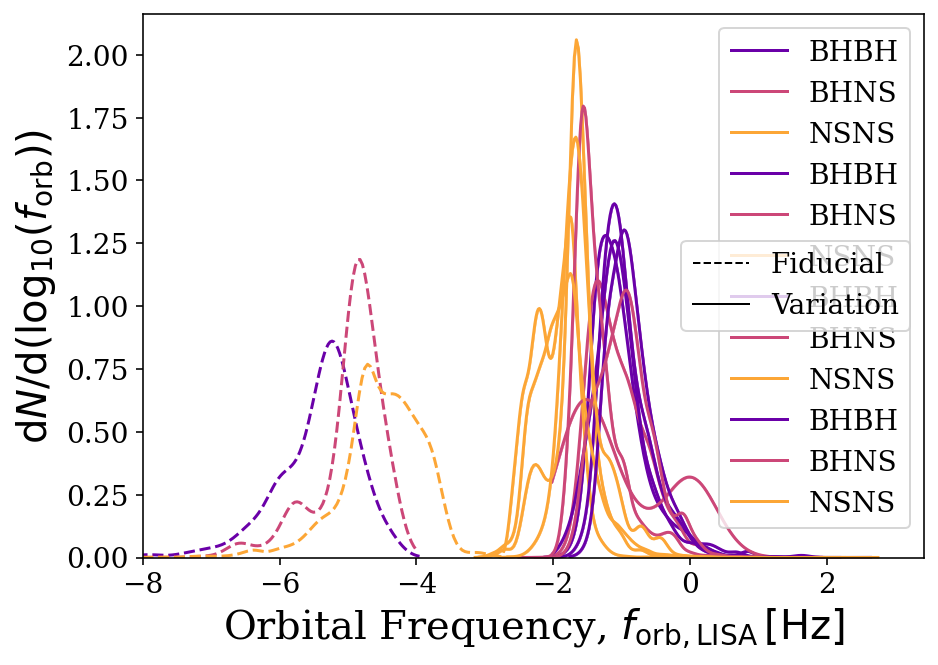

In [201]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4

bootstraps = None
    
for model, style in [(0, "--"), (6, "-"), (7, "-"), (8, "-"), (9, "-")]:
    print(variations[model]["long"])
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 1

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        if os.path.isfile(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"])):
            with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
                data = f["simulation"][...].squeeze()

            f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_DCO"] * u.AU)

            # plot the distance distribution
            print("Plotting tau for", dco_type)


            if bootstraps is not None:
                ax = boots.bootstrapped_kde(np.log10(data["a_DCO"]), data["weight"], data["seed"],
                                            ax=ax, color=dco_colours[dco_type], label=dco_type,
                                            bootstraps=bootstraps)
            else:
                sorted_order = np.argsort(data["seed"])
                sorted_seeds = data["seed"][sorted_order]
                _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
                res = np.split(sorted_order, starts[1:])
                inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
                ax.plot(*boots.kde(np.log10(f_orb_LISA.value[inds]), weights=data["weight"][inds] * counts),
                        color=dco_colours[dco_type], linestyle=style)
            
ax.set_xlabel(r"Orbital Frequency, $f_{\rm orb, LISA} \, [\rm Hz]$")
ax.set_xlim(left=-8)

# ax.set_xticks([-5, -4, -3, -2])
# ax.set_xticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])
# ax.xaxis.set_minor_locator(FixedLocator(get_log_ticks(*ax.get_xlim())))

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (f_{\rm orb}))$")


first_legend = plt.legend(loc='upper right', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Fiducial", "Variation"],
          loc='center right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

# plt.savefig("../figures/mBH_rapid_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

Fiducial
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS
CE efficiency $\alpha = 0.1$
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS


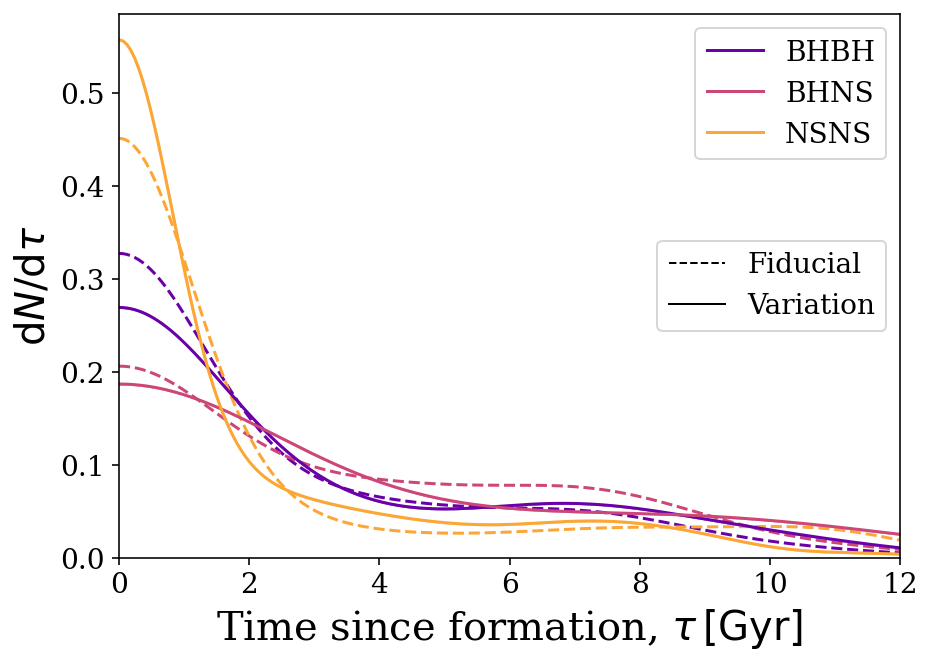

In [157]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4

bootstraps = None
    
for model, style in [(0, "--"), (6, "-")]:
    print(variations[model]["long"])
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 1

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()

        # plot the distance distribution
        print("Plotting tau for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(data["tau"], data["weight"], data["seed"],
                                          ax=ax, color=dco_colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps, lower_bound=0.0, bw_adjust=1.5)
        else:
            sorted_order = np.argsort(data["seed"])
            sorted_seeds = data["seed"][sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(data["tau"][inds], weights=data["weight"][inds] * counts, lower_bound=0.0, bw_adjust=1.5),
                            color=dco_colours[dco_type], linestyle=style)
            
ax.set_xlabel(r"Time since formation, $\tau \, [\rm Gyr]$")
ax.set_xlim(0, 12)
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}\tau$")


first_legend = plt.legend(loc='upper right', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Fiducial", "Variation"],
          loc='center right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

# plt.savefig("../figures/mBH_rapid_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

Fiducial
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS
Wolf-Rayet wind factor $f_{\rm WR} = 0.1$
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS


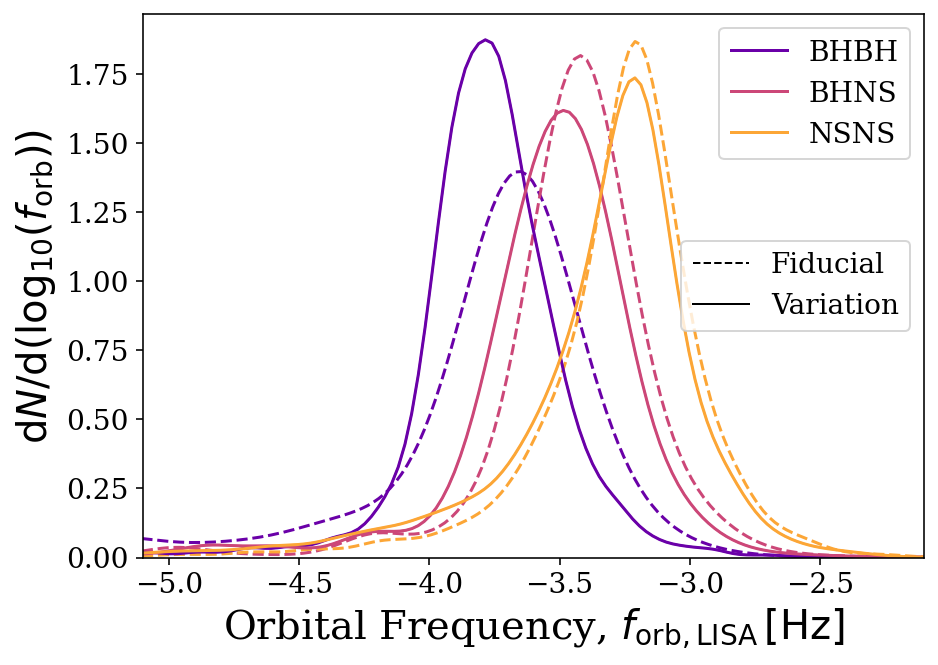

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4

bootstraps = None
    
for model, style in [(0, "--"), (18, "-")]:
    print(variations[model]["long"])
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 1

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        if os.path.isfile(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"])):
            with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
                data = f["simulation"][...].squeeze()

            f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)

            # plot the distance distribution
            print("Plotting tau for", dco_type)


            if bootstraps is not None:
                ax = boots.bootstrapped_kde(np.log10(f_orb_LISA.value), data["weight"], data["seed"],
                                            ax=ax, color=dco_colours[dco_type], label=dco_type,
                                            bootstraps=bootstraps)
            else:
                sorted_order = np.argsort(data["seed"])
                sorted_seeds = data["seed"][sorted_order]
                _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
                res = np.split(sorted_order, starts[1:])
                inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
                ax.plot(*boots.kde(np.log10(f_orb_LISA.value[inds]), weights=data["weight"][inds] * counts),
                        color=dco_colours[dco_type], linestyle=style)
            
ax.set_xlabel(r"Orbital Frequency, $f_{\rm orb, LISA} \, [\rm Hz]$")
ax.set_xlim(-5.1, -2.1)

# ax.set_xticks([-5, -4, -3, -2])
# ax.set_xticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])
# ax.xaxis.set_minor_locator(FixedLocator(get_log_ticks(*ax.get_xlim())))

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (f_{\rm orb}))$")


first_legend = plt.legend(loc='upper right', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Fiducial", "Variation"],
          loc='center right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

# plt.savefig("../figures/mBH_rapid_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Simple Milky Way stuff

../../simulation/data/simple_mw_simulation/simple_mw_
Plotting mass for BHBH
Plotting mass for BHNS
../../simulation/data/simulation/
Plotting mass for BHBH
Plotting mass for BHNS


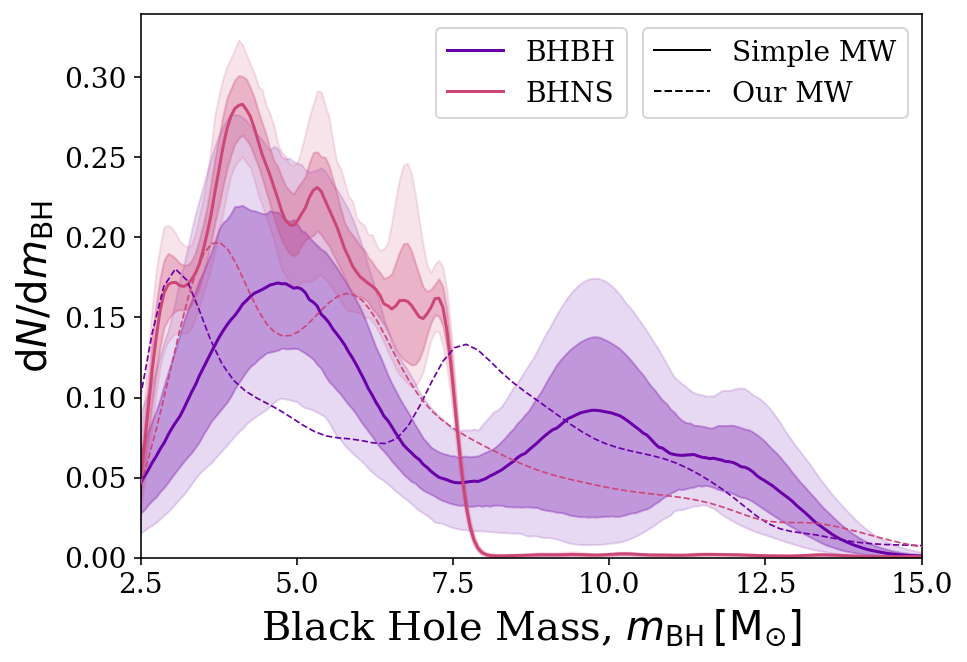

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4
    
for folder, style in [("../../simulation/data/simple_mw_simulation/simple_mw_", "-"), (sim_folder, "--")]:
    print(folder)
    if folder == sim_folder:
        bootstraps = None
    else:
        bootstraps = 200

    for i, dco_type in enumerate(["BHBH", "BHNS"]):
        # open corresponding COMPAS file
        with h5.File(folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
        # work out which masses are the BH and NS masses
        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))

        # plot the distance distribution
        print("Plotting mass for", dco_type)
        bw_adjust = 0.5
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=bw_adjust,
                                                    ax=ax, color=dco_colours[dco_type], label=dco_type,
                                                    bootstraps=bootstraps, lower_bound=0.0, x_min=2.5, x_max=15)
        else:
            sorted_order = np.argsort(mass_seeds)
            sorted_seeds = mass_seeds[sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(mBH[inds], weights=mass_weights[inds] * counts, lower_bound=0.0, bw_adjust=bw_adjust, x_min=2.5),
                                color=dco_colours[dco_type], linestyle=style, lw=0.85, zorder=10)

ax.set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
ax.set_xlim(2.5, 15)
ax.set_xticks([2.5, 5, 7.5, 10, 12.5, 15])

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m_{\rm BH}$")


first_legend = plt.legend(loc='upper center', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="black", lw=1, linestyle="--")]
ax.legend(handles=custom_lines, labels=["Simple MW", "Our MW"],
          loc='upper right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

plt.savefig("../figures/mBH_simple_mw_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

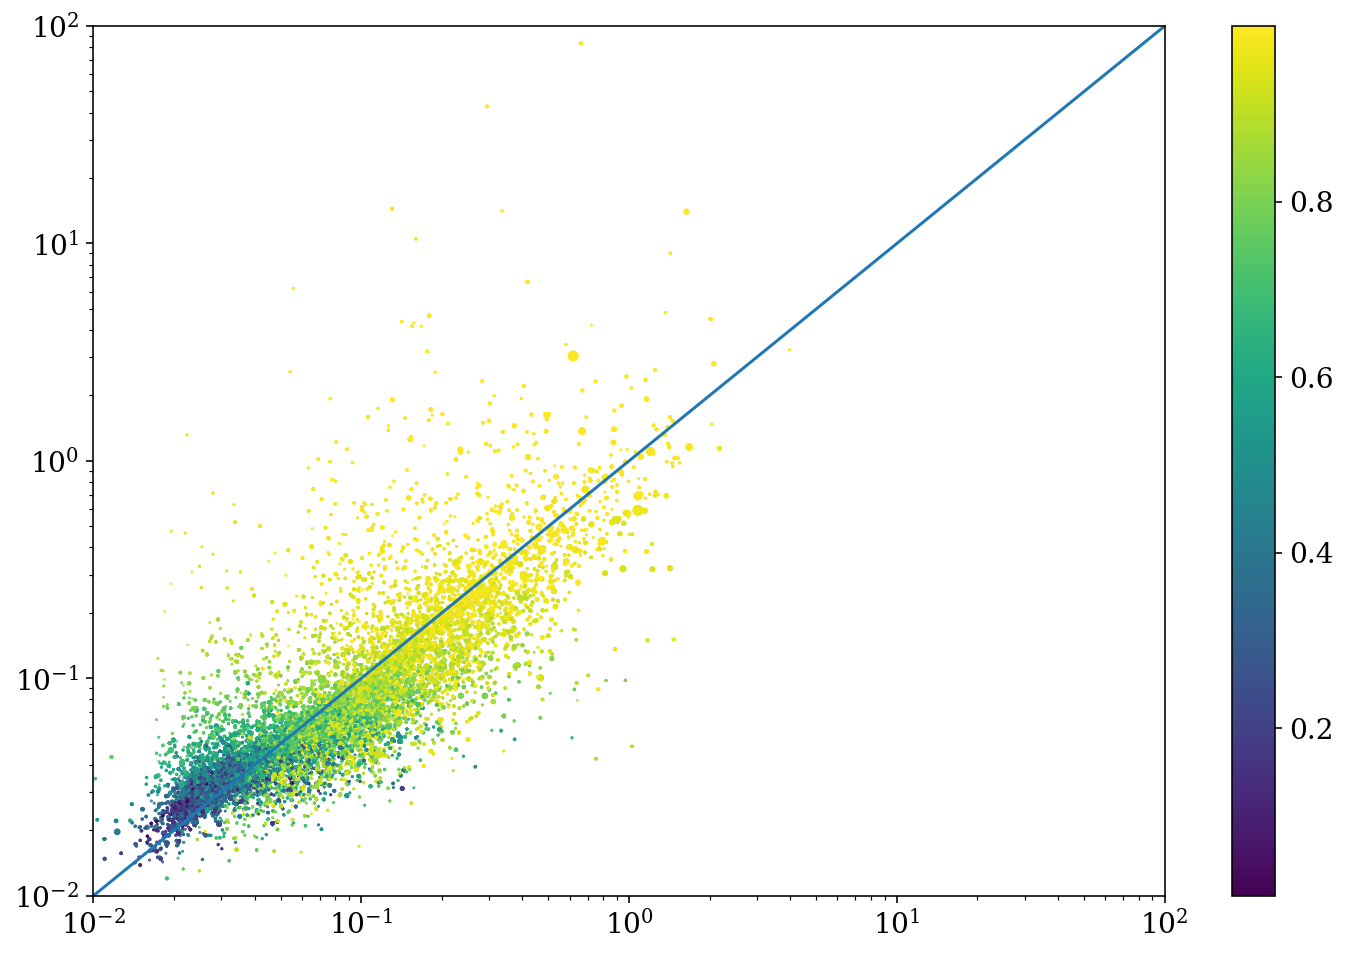

In [62]:
for dco_type in ["BHNS"]:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "alpha0_1"), "r") as f:
        data = f["simulation"][...].squeeze()

    for i in [1, 2]:
        mask = data["channel"] == i
        scatter = plt.scatter(data["a_pre_SN2"][mask], data["a_DCO"][mask], s=data["weight"][mask] * 10, c=data["e_DCO"][mask])
    
plt.plot([1e-2, 1e2], [1e-2, 1e2])
plt.colorbar(scatter)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-2, 1e2)
plt.ylim(1e-2, 1e2)

plt.show()

# Common Envelope NSNS stuff

Plotting var for Fiducial
Plotting var for CE efficiency $\alpha = 10.0$


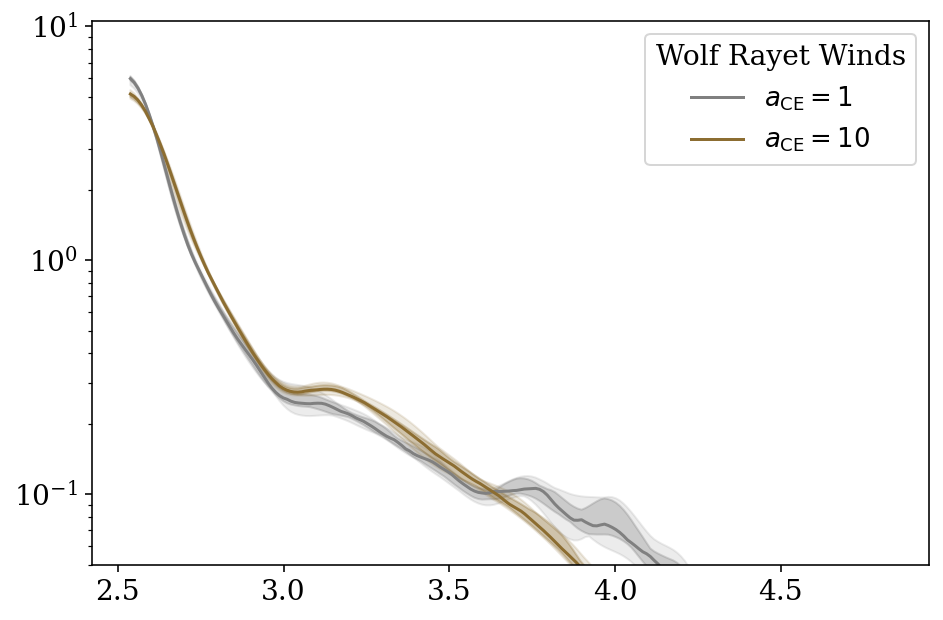

In [259]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
#for model, label in [(0, r"$a_{\rm CE} = 1$"), (6, r"$a_{\rm CE} = 0.1$"), (7, r"$a_{\rm CE} = 0.5$"), (8, r"$a_{\rm CE} = 2$"), (9, r"$a_{\rm CE} = 10$")]:
for model, label in [(0, r"$a_{\rm CE} = 1$"), (9, r"$a_{\rm CE} = 10$")]:
    bootstraps = 10
        
    var = np.array([])
    weights = np.array([])
    seeds = np.array([])

    for i, dco_type in enumerate(["NSNS"]):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            var = np.concatenate((var, data["m_1"] + data["m_2"]))
            weights = np.concatenate((weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"]))
    
    # plot the distance distribution
    print("Plotting var for", variations[model]["long"])
    ax = boots.bootstrapped_kde(var, weights, seeds, normalisation=1,#detections[2, model].sum() / detections[2, 0].sum(),
                                ax=ax, color=variations[model]["colour"], label=label,
                                bootstraps=bootstraps, lower_bound=1.26*2)

ax.set_yscale("log")
ax.set_ylim(bottom=5e-2)

leg = ax.legend(loc='upper right', fontsize=0.65 * fs, title="Wolf Rayet Winds")
leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

plt.show()

Plotting var for Fiducial
Plotting var for CE efficiency $\alpha = 10.0$


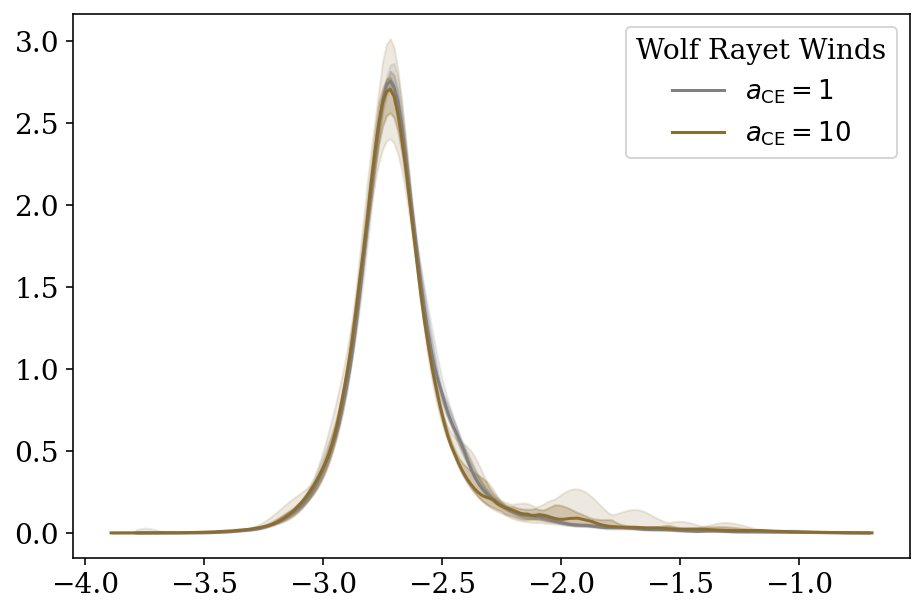

In [255]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
#for model, label in [(0, r"$a_{\rm CE} = 1$"), (6, r"$a_{\rm CE} = 0.1$"), (7, r"$a_{\rm CE} = 0.5$"), (8, r"$a_{\rm CE} = 2$"), (9, r"$a_{\rm CE} = 10$")]:
for model, label in [(0, r"$a_{\rm CE} = 1$"), (9, r"$a_{\rm CE} = 10$")]:
    bootstraps = 10
        
    var = np.array([])
    weights = np.array([])
    seeds = np.array([])

    for i, dco_type in enumerate(["NSNS"]):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            var = np.concatenate((var, np.log10(data["a_LISA"])))
            weights = np.concatenate((weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"]))
    
    # plot the distance distribution
    print("Plotting var for", variations[model]["long"])
    ax = boots.bootstrapped_kde(var, weights, seeds, normalisation=1,#detections[2, model].sum() / detections[2, 0].sum(),
                                ax=ax, color=variations[model]["colour"], label=label,
                                bootstraps=bootstraps)

# ax.set_xlim()

leg = ax.legend(loc='upper right', fontsize=0.65 * fs, title="Wolf Rayet Winds")
leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

plt.show()

Plotting var for Fiducial
Plotting var for CE efficiency $\alpha = 10.0$


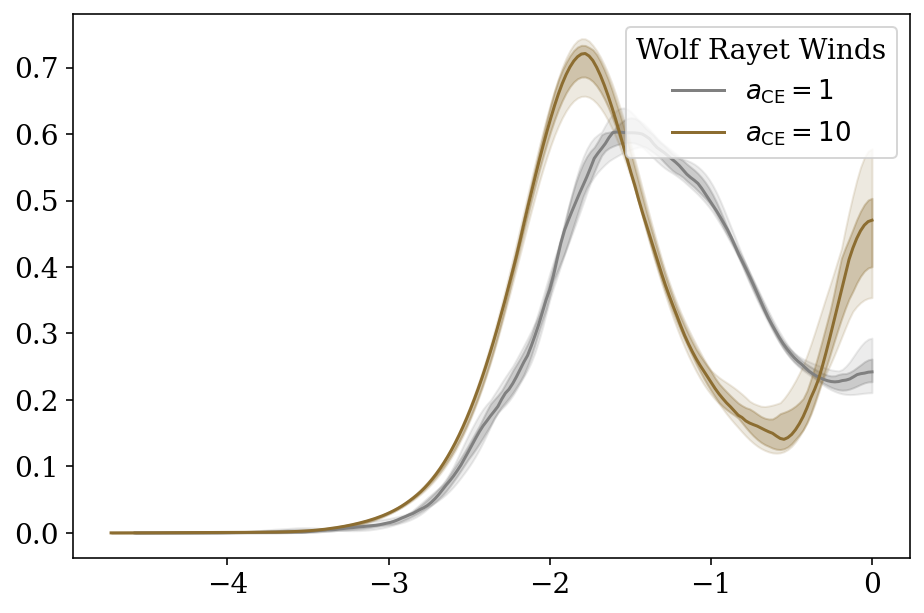

In [264]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
# for model, label in [(0, r"$a_{\rm CE} = 1$"), (6, r"$a_{\rm CE} = 0.1$"), (7, r"$a_{\rm CE} = 0.5$"), (8, r"$a_{\rm CE} = 2$"), (9, r"$a_{\rm CE} = 10$")]:
for model, label in [(0, r"$a_{\rm CE} = 1$"), (9, r"$a_{\rm CE} = 10$")]:
    bootstraps = 10
        
    var = np.array([])
    weights = np.array([])
    seeds = np.array([])

    for i, dco_type in enumerate(["NSNS"]):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            var = np.concatenate((var, np.log10(data["e_LISA"])))
            weights = np.concatenate((weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"]))
    
    # plot the distance distribution
    print("Plotting var for", variations[model]["long"])
    ax = boots.bootstrapped_kde(var, weights, seeds, normalisation=1,#detections[2, model].sum() / detections[2, 0].sum(),
                                ax=ax, color=variations[model]["colour"], label=label,
                                bootstraps=bootstraps, upper_bound=0)

# ax.set_xlim()

leg = ax.legend(loc='upper right', fontsize=0.65 * fs, title="Wolf Rayet Winds")
leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

plt.show()

# What will we actually see?

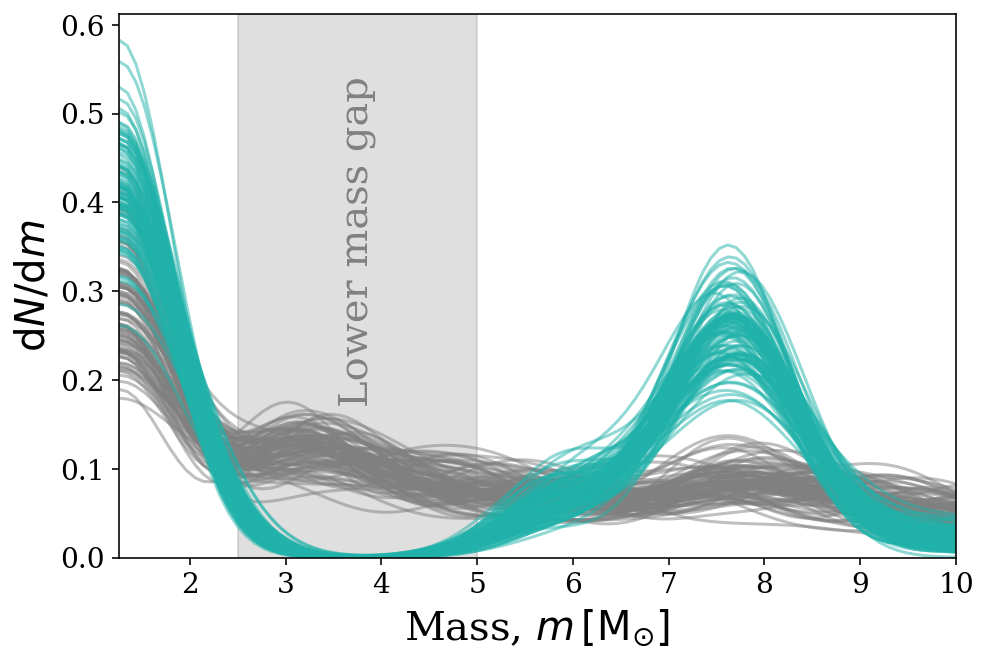

In [290]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
x_vals = np.linspace(1.26, 10, 100)
    
for model, style in [(0, "--"), (11, "-")]:        
    mass = np.array([])
    weights = np.array([])
    seeds = np.array([])

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            mass = np.concatenate((mass, data["m_1"], data["m_2"]))
            weights = np.concatenate((weights, new_weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"], -1 * data["seed"]))
            
    SAMPLES = 100
    DETECTIONS = detections[:, model].mean(axis=1).sum().round(0).astype(int)
    sampled_stuff = np.zeros((SAMPLES, DETECTIONS))
    
    for sample in range(SAMPLES):
        sampled_stuff[sample] = np.random.choice(mass, p=weights / weights.sum(), replace=True, size=DETECTIONS)
        
        plt.plot(x_vals, boots.MirroredKDE(sampled_stuff[sample], lower_bound=1.26, bw_adjust=0.4).evaluate(x_vals), color=variations[model]["colour"], alpha=0.5)
#         plt.hist(sampled_stuff[sample], histtype="step", color=variations[model]["colour"], bins=20, density=True)    
            
ax.axvspan(2.5, 5.0, color="grey", alpha=0.25)
ax.annotate("Lower mass gap", xy=(3.75, 0.17), color="grey", rotation=90, ha="center", va="bottom", fontsize=fs)

ax.set_xlabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_xlim(1.26, 10)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m$")

# leg = ax.legend(loc='upper right', fontsize=0.65 * fs, ncol=2, columnspacing=1, title="Remnant Mass Prescription")
# leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0)

# plt.savefig("../figures/lower_mass_gap_rapid_variation_detection_weighted.pdf", format="pdf", bbox_inches="tight")

plt.show()

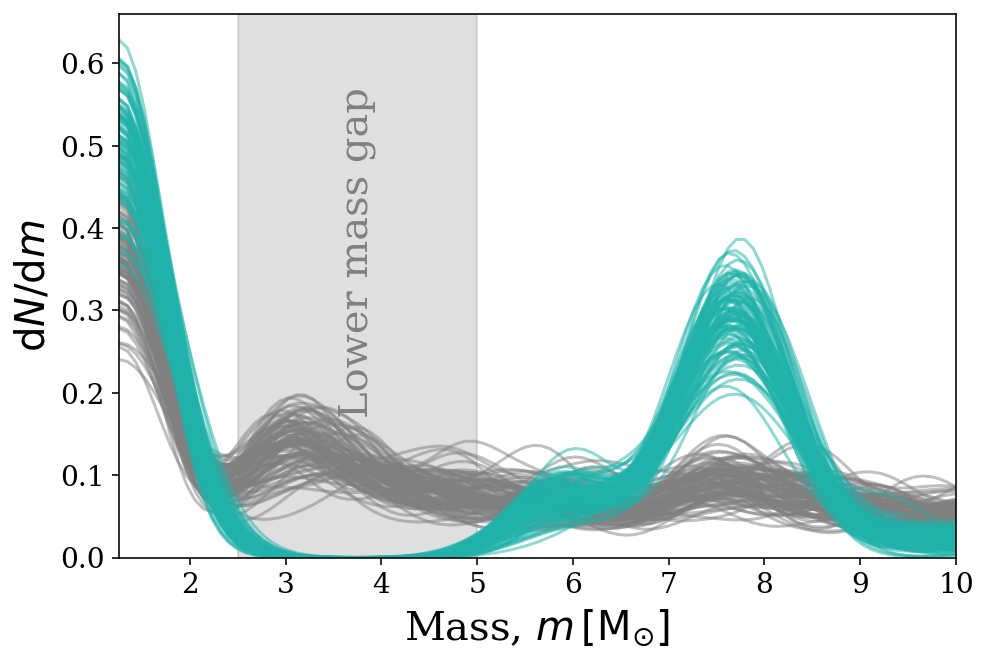

In [296]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
x_vals = np.linspace(1.26, 10, 100)

mass = np.array([None, None, None])
weights = np.array([None, None, None])
    
for model, style in [(0, "--"), (11, "-")]:        
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            mass[i] = np.concatenate((data["m_1"], data["m_2"]))
            weights[i] = np.concatenate((new_weights, new_weights))
            
    # how many samples
    SAMPLES = 100
    
    # how many detections of each type
    detection_totals = detections[:, model].mean(axis=1).round(0).astype(int)
    DETECTIONS = detection_totals.sum()
    sampled_stuff = np.zeros((SAMPLES, DETECTIONS))
    
    for sample in range(SAMPLES):
        # draw samples of each type
        sampled_stuff[sample][:detection_totals[0]] = np.random.choice(mass[0], p=weights[0] / weights[0].sum(), replace=True, size=detection_totals[0])
        sampled_stuff[sample][detection_totals[0]:detection_totals[0] + detection_totals[1]] = np.random.choice(mass[1], p=weights[1] / weights[1].sum(), replace=True, size=detection_totals[1])
        sampled_stuff[sample][detection_totals[0] + detection_totals[1]:] = np.random.choice(mass[2], p=weights[2] / weights[2].sum(), replace=True, size=detection_totals[2])

        # plot the overall distribution we've created
        plt.plot(x_vals, boots.MirroredKDE(sampled_stuff[sample], lower_bound=1.26, bw_adjust=0.3).evaluate(x_vals), color=variations[model]["colour"], alpha=0.5)
    #         plt.hist(sampled_stuff[sample], histtype="step", color=variations[model]["colour"], bins=20, density=True)    
            
ax.axvspan(2.5, 5.0, color="grey", alpha=0.25)
ax.annotate("Lower mass gap", xy=(3.75, 0.17), color="grey", rotation=90, ha="center", va="bottom", fontsize=fs)

ax.set_xlabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_xlim(1.26, 10)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m$")

# leg = ax.legend(loc='upper right', fontsize=0.65 * fs, ncol=2, columnspacing=1, title="Remnant Mass Prescription")
# leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0)

# plt.savefig("../figures/lower_mass_gap_rapid_variation_detection_weighted.pdf", format="pdf", bbox_inches="tight")

plt.show()

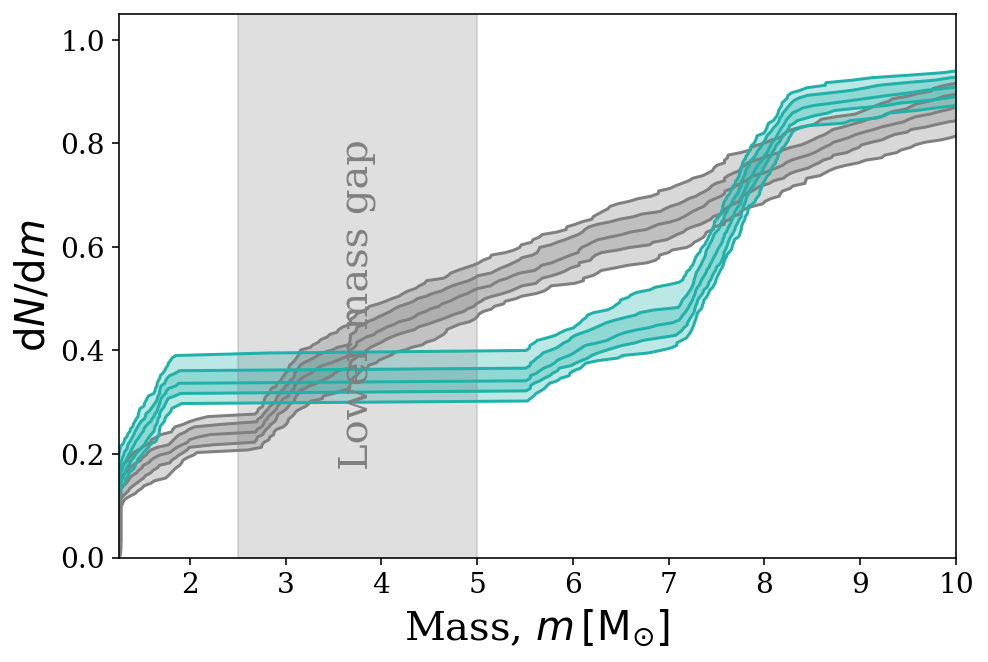

In [324]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
x_vals = np.linspace(1.26, 10, 100)

mass = np.array([None, None, None])
weights = np.array([None, None, None])
    
for model, style in [(0, "--"), (11, "-")]:        
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            mass[i] = np.concatenate((data["m_1"], data["m_2"]))
            weights[i] = np.concatenate((new_weights, new_weights))
            
    # how many samples
    SAMPLES = 100
    
    # how many detections of each type
    detection_totals = detections[:, model].mean(axis=1).round(0).astype(int)
    DETECTIONS = detection_totals.sum()
    sampled_stuff = np.zeros((SAMPLES, DETECTIONS))
    
    for sample in range(SAMPLES):
        # draw samples of each type
        sampled_stuff[sample][:detection_totals[0]] = np.random.choice(mass[0], p=weights[0] / weights[0].sum(), replace=True, size=detection_totals[0])
        sampled_stuff[sample][detection_totals[0]:detection_totals[0] + detection_totals[1]] = np.random.choice(mass[1], p=weights[1] / weights[1].sum(), replace=True, size=detection_totals[1])
        sampled_stuff[sample][detection_totals[0] + detection_totals[1]:] = np.random.choice(mass[2], p=weights[2] / weights[2].sum(), replace=True, size=detection_totals[2])

        sampled_stuff[sample] = np.sort(sampled_stuff[sample])
        
        # plot the overall distribution we've created
#         plt.plot(x_vals, boots.MirroredKDE(sampled_stuff[sample], lower_bound=1.26, bw_adjust=0.3).evaluate(x_vals), color=variations[model]["colour"], alpha=0.5)
#         plt.hist(sampled_stuff[sample], histtype="step", color=variations[model]["colour"], bins=DETECTIONS, density=True, cumulative=True, alpha=0.5)    
    
    sampled_stuff = sampled_stuff.T
    
    y_range = np.linspace(1, DETECTIONS, DETECTIONS) / DETECTIONS
        
    # calculate uncertainty boundaries and median
    two_sigma_below = np.sort(np.percentile(sampled_stuff, 2.270, axis=1))
    one_sigma_below = np.sort(np.percentile(sampled_stuff, 15.89, axis=1))
    median          = np.sort(np.percentile(sampled_stuff, 50.00, axis=1))
    one_sigma_above = np.sort(np.percentile(sampled_stuff, 84.10, axis=1))
    two_sigma_above = np.sort(np.percentile(sampled_stuff, 97.73, axis=1))

    # plot separating lines
    ax.plot(two_sigma_below, y_range, color=variations[model]["colour"])
    ax.plot(one_sigma_below, y_range, color=variations[model]["colour"])
    ax.plot(median, y_range, color=variations[model]["colour"])
    ax.plot(one_sigma_above, y_range, color=variations[model]["colour"])
    ax.plot(two_sigma_above, y_range, color=variations[model]["colour"])

    # fill areas with different transparencies
    ax.fill_betweenx(y_range, two_sigma_below, one_sigma_below, color=variations[model]["colour"], alpha=0.3)
    ax.fill_betweenx(y_range, one_sigma_below, one_sigma_above, color=variations[model]["colour"], alpha=0.5)
    ax.fill_betweenx(y_range, one_sigma_above, two_sigma_above, color=variations[model]["colour"], alpha=0.3)
            
ax.axvspan(2.5, 5.0, color="grey", alpha=0.25)
ax.annotate("Lower mass gap", xy=(3.75, 0.17), color="grey", rotation=90, ha="center", va="bottom", fontsize=fs)

ax.set_xlabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_xlim(1.26, 10)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m$")

# leg = ax.legend(loc='upper right', fontsize=0.65 * fs, ncol=2, columnspacing=1, title="Remnant Mass Prescription")
# leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0)


plt.show()

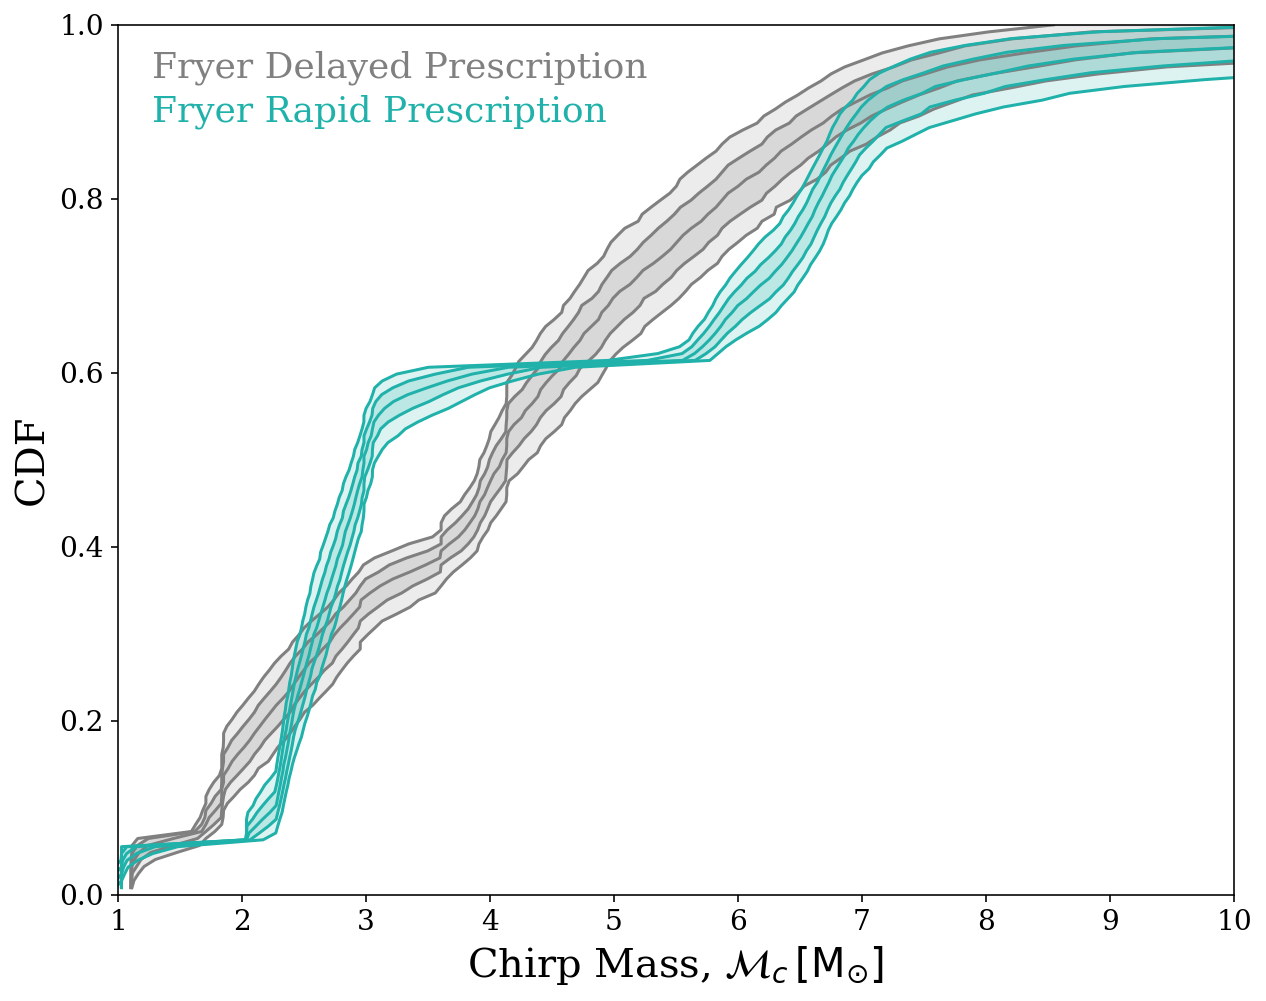

In [364]:
fig, ax = plt.subplots(figsize=(10, 8))
lw = 4
    
x_vals = np.linspace(1.26, 10, 100)

mass = np.array([None, None, None])
weights = np.array([None, None, None])
    
for model, style in [(0, "--"), (11, "-")]:        
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            mass[i] = legwork.utils.chirp_mass(data["m_1"], data["m_2"])
            weights[i] = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
    # how many samples
    SAMPLES = 1000
    
    # how many detections of each type
    detection_totals = (detections[:, model].mean(axis=1).round(0).astype(int) * 1).astype(int)
    DETECTIONS = detection_totals.sum()
    sampled_stuff = np.zeros((SAMPLES, DETECTIONS))
    
    for sample in range(SAMPLES):
        # draw samples of each type
        sampled_stuff[sample][:detection_totals[0]] = np.random.choice(mass[0], p=weights[0] / weights[0].sum(), replace=True, size=detection_totals[0])
        sampled_stuff[sample][detection_totals[0]:detection_totals[0] + detection_totals[1]] = np.random.choice(mass[1], p=weights[1] / weights[1].sum(), replace=True, size=detection_totals[1])
        sampled_stuff[sample][detection_totals[0] + detection_totals[1]:] = np.random.choice(mass[2], p=weights[2] / weights[2].sum(), replace=True, size=detection_totals[2])

        sampled_stuff[sample] = np.sort(sampled_stuff[sample])
        
    sampled_stuff = sampled_stuff.T
    
    y_range = np.linspace(1, DETECTIONS, DETECTIONS) / DETECTIONS
        
    # calculate uncertainty boundaries and median
    two_sigma_below = np.sort(np.percentile(sampled_stuff, 2.270, axis=1))
    one_sigma_below = np.sort(np.percentile(sampled_stuff, 15.89, axis=1))
    median          = np.sort(np.percentile(sampled_stuff, 50.00, axis=1))
    one_sigma_above = np.sort(np.percentile(sampled_stuff, 84.10, axis=1))
    two_sigma_above = np.sort(np.percentile(sampled_stuff, 97.73, axis=1))

    # plot separating lines
    ax.plot(two_sigma_below, y_range, color=variations[model]["colour"])
    ax.plot(one_sigma_below, y_range, color=variations[model]["colour"])
    ax.plot(median, y_range, color=variations[model]["colour"])
    ax.plot(one_sigma_above, y_range, color=variations[model]["colour"])
    ax.plot(two_sigma_above, y_range, color=variations[model]["colour"])

    # fill areas with different transparencies
    ax.fill_betweenx(y_range, two_sigma_below, one_sigma_below, color=variations[model]["colour"], alpha=0.15)
    ax.fill_betweenx(y_range, one_sigma_below, one_sigma_above, color=variations[model]["colour"], alpha=0.3)
    ax.fill_betweenx(y_range, one_sigma_above, two_sigma_above, color=variations[model]["colour"], alpha=0.15)
            
# ax.annotate("Remnant Mass Prescription", xy=(0.03, 0.97), xycoords="axes fraction", va="top", fontsize=fs, color="black")
ax.annotate("Fryer Delayed Prescription", xy=(0.03, 0.97), xycoords="axes fraction", va="top", fontsize=0.9*fs, color=variations[0]["colour"])
ax.annotate("Fryer Rapid Prescription", xy=(0.03, 0.92), xycoords="axes fraction", va="top", fontsize=0.9*fs, color=variations[11]["colour"])

ax.set_xlabel(r"Chirp Mass, $\mathcal{M}_c \, [\rm M_{\odot}]$")
ax.set_xlim(1, 10)

ax.set_ylabel("CDF")

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0, 1)

# ax.annotate(r"$\Delta \mathcal{M}_c / \mathcal{M}_c < 0.1$", xy=(0.98, 0.02), ha="right", xycoords="axes fraction", fontsize=fs)

plt.show()

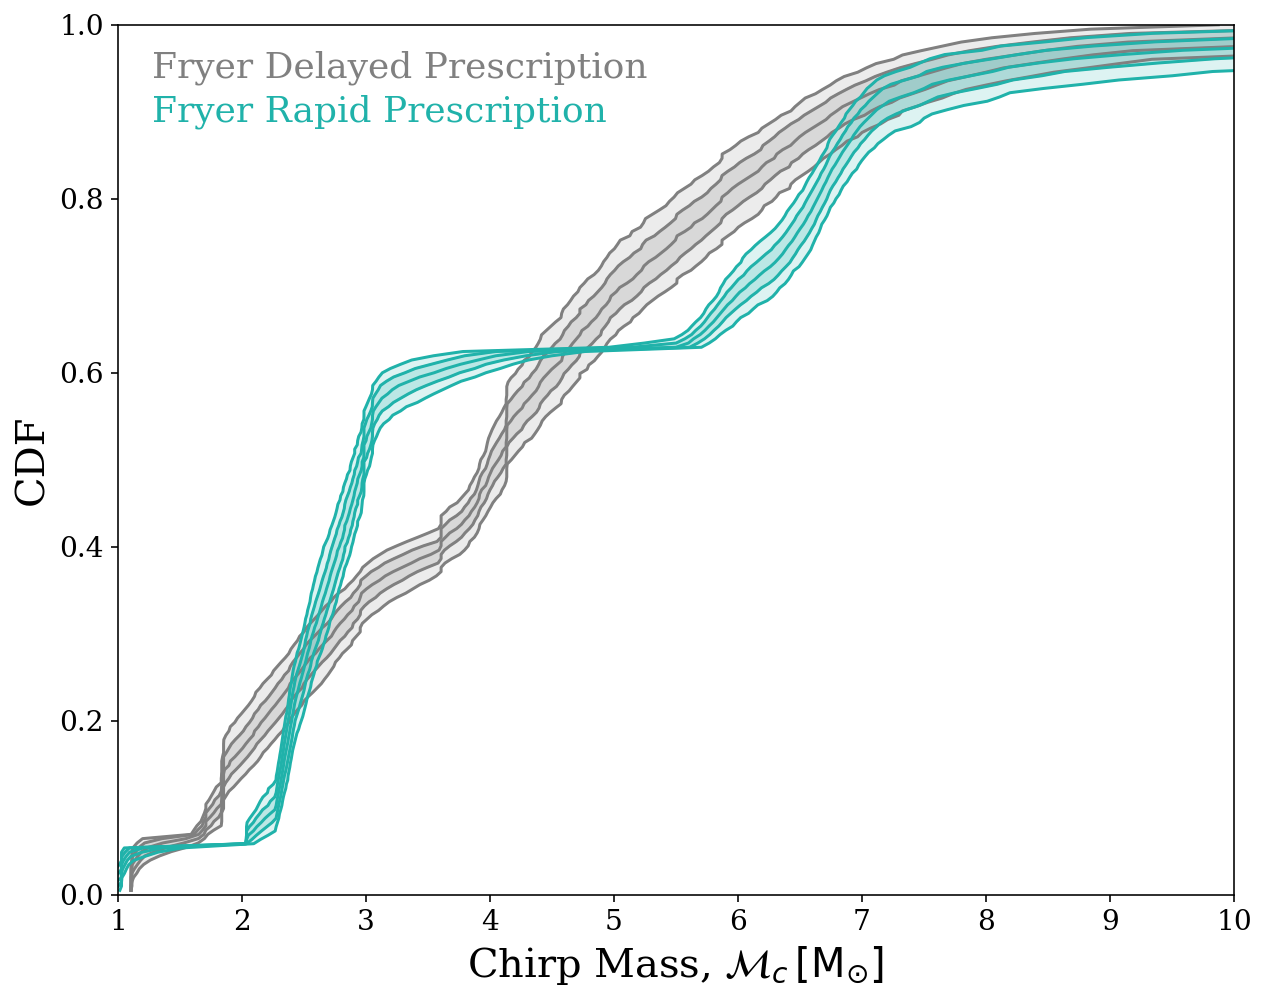

In [356]:
fig, ax = plt.subplots(figsize=(10, 8))
lw = 4
    
x_vals = np.linspace(1.26, 10, 100)

mass = np.array([None, None, None])
weights = np.array([None, None, None])
    
for model, style in [(0, "--"), (11, "-")]:        
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            mass[i] = legwork.utils.chirp_mass(data["m_1"], data["m_2"])
            weights[i] = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
    # how many samples
    SAMPLES = 1000
    
    # how many detections of each type
    detection_totals = detections_10yr[:, model].mean(axis=1).round(0).astype(int)
    DETECTIONS = detection_totals.sum()
    sampled_stuff = np.zeros((SAMPLES, DETECTIONS))
    
    for sample in range(SAMPLES):
        # draw samples of each type
        sampled_stuff[sample][:detection_totals[0]] = np.random.choice(mass[0], p=weights[0] / weights[0].sum(), replace=True, size=detection_totals[0])
        sampled_stuff[sample][detection_totals[0]:detection_totals[0] + detection_totals[1]] = np.random.choice(mass[1], p=weights[1] / weights[1].sum(), replace=True, size=detection_totals[1])
        sampled_stuff[sample][detection_totals[0] + detection_totals[1]:] = np.random.choice(mass[2], p=weights[2] / weights[2].sum(), replace=True, size=detection_totals[2])

        sampled_stuff[sample] = np.sort(sampled_stuff[sample])
        
    sampled_stuff = sampled_stuff.T
    
    y_range = np.linspace(1, DETECTIONS, DETECTIONS) / DETECTIONS
        
    # calculate uncertainty boundaries and median
    two_sigma_below = np.sort(np.percentile(sampled_stuff, 2.270, axis=1))
    one_sigma_below = np.sort(np.percentile(sampled_stuff, 15.89, axis=1))
    median          = np.sort(np.percentile(sampled_stuff, 50.00, axis=1))
    one_sigma_above = np.sort(np.percentile(sampled_stuff, 84.10, axis=1))
    two_sigma_above = np.sort(np.percentile(sampled_stuff, 97.73, axis=1))

    # plot separating lines
    ax.plot(two_sigma_below, y_range, color=variations[model]["colour"])
    ax.plot(one_sigma_below, y_range, color=variations[model]["colour"])
    ax.plot(median, y_range, color=variations[model]["colour"])
    ax.plot(one_sigma_above, y_range, color=variations[model]["colour"])
    ax.plot(two_sigma_above, y_range, color=variations[model]["colour"])

    # fill areas with different transparencies
    ax.fill_betweenx(y_range, two_sigma_below, one_sigma_below, color=variations[model]["colour"], alpha=0.15)
    ax.fill_betweenx(y_range, one_sigma_below, one_sigma_above, color=variations[model]["colour"], alpha=0.3)
    ax.fill_betweenx(y_range, one_sigma_above, two_sigma_above, color=variations[model]["colour"], alpha=0.15)
            
# ax.annotate("Remnant Mass Prescription", xy=(0.03, 0.97), xycoords="axes fraction", va="top", fontsize=fs, color="black")
ax.annotate("Fryer Delayed Prescription", xy=(0.03, 0.97), xycoords="axes fraction", va="top", fontsize=0.9*fs, color=variations[0]["colour"])
ax.annotate("Fryer Rapid Prescription", xy=(0.03, 0.92), xycoords="axes fraction", va="top", fontsize=0.9*fs, color=variations[11]["colour"])

ax.set_xlabel(r"Chirp Mass, $\mathcal{M}_c \, [\rm M_{\odot}]$")
ax.set_xlim(1, 10)

ax.set_ylabel("CDF")

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0, 1)

plt.show()

# Common Envelope Trends

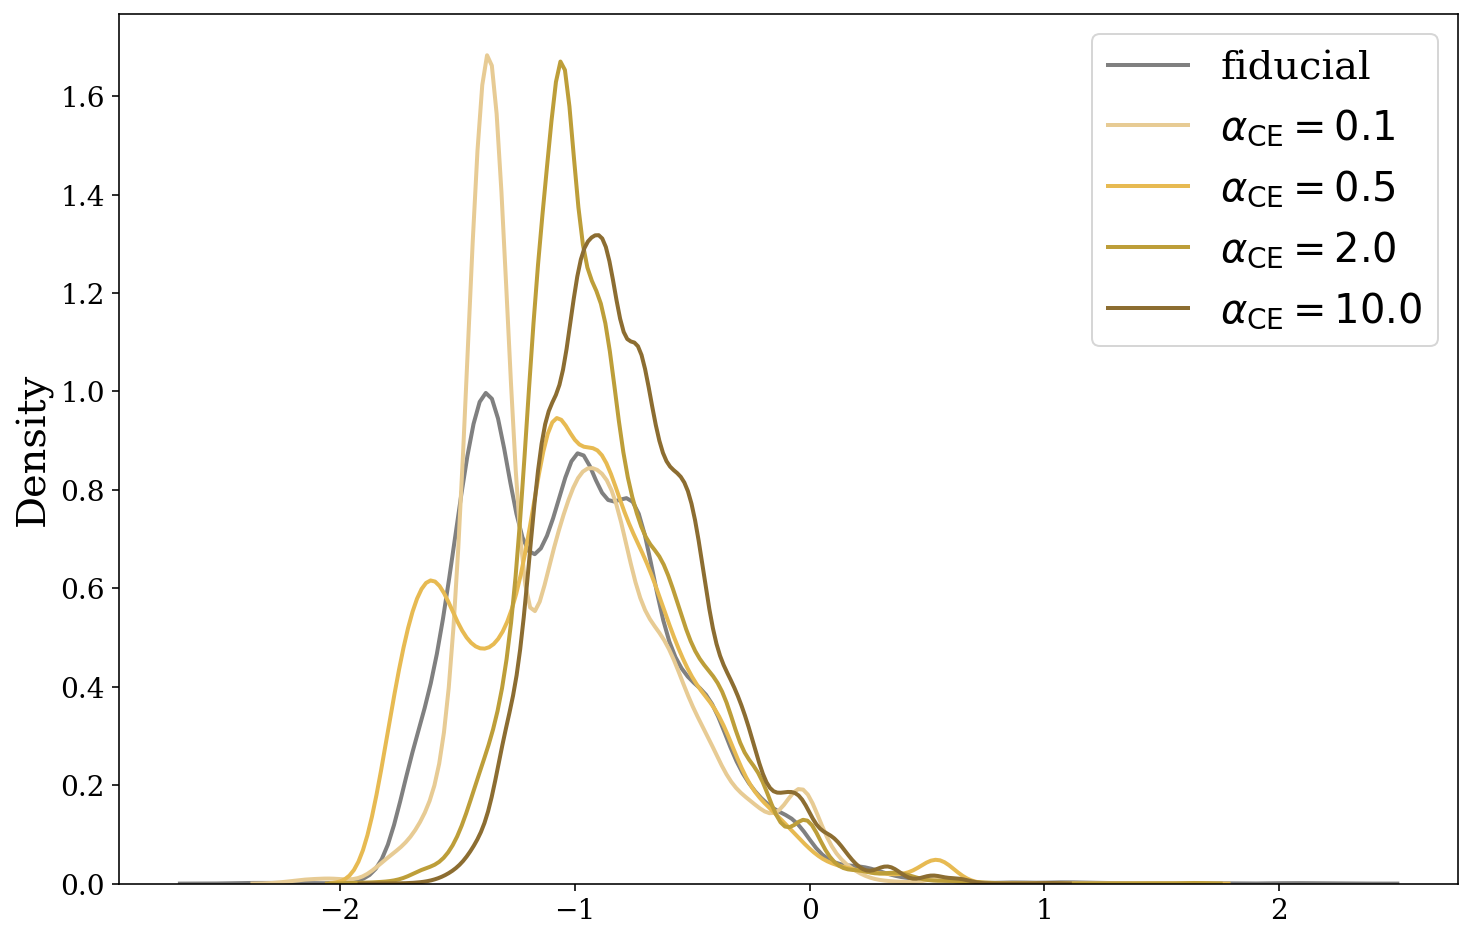

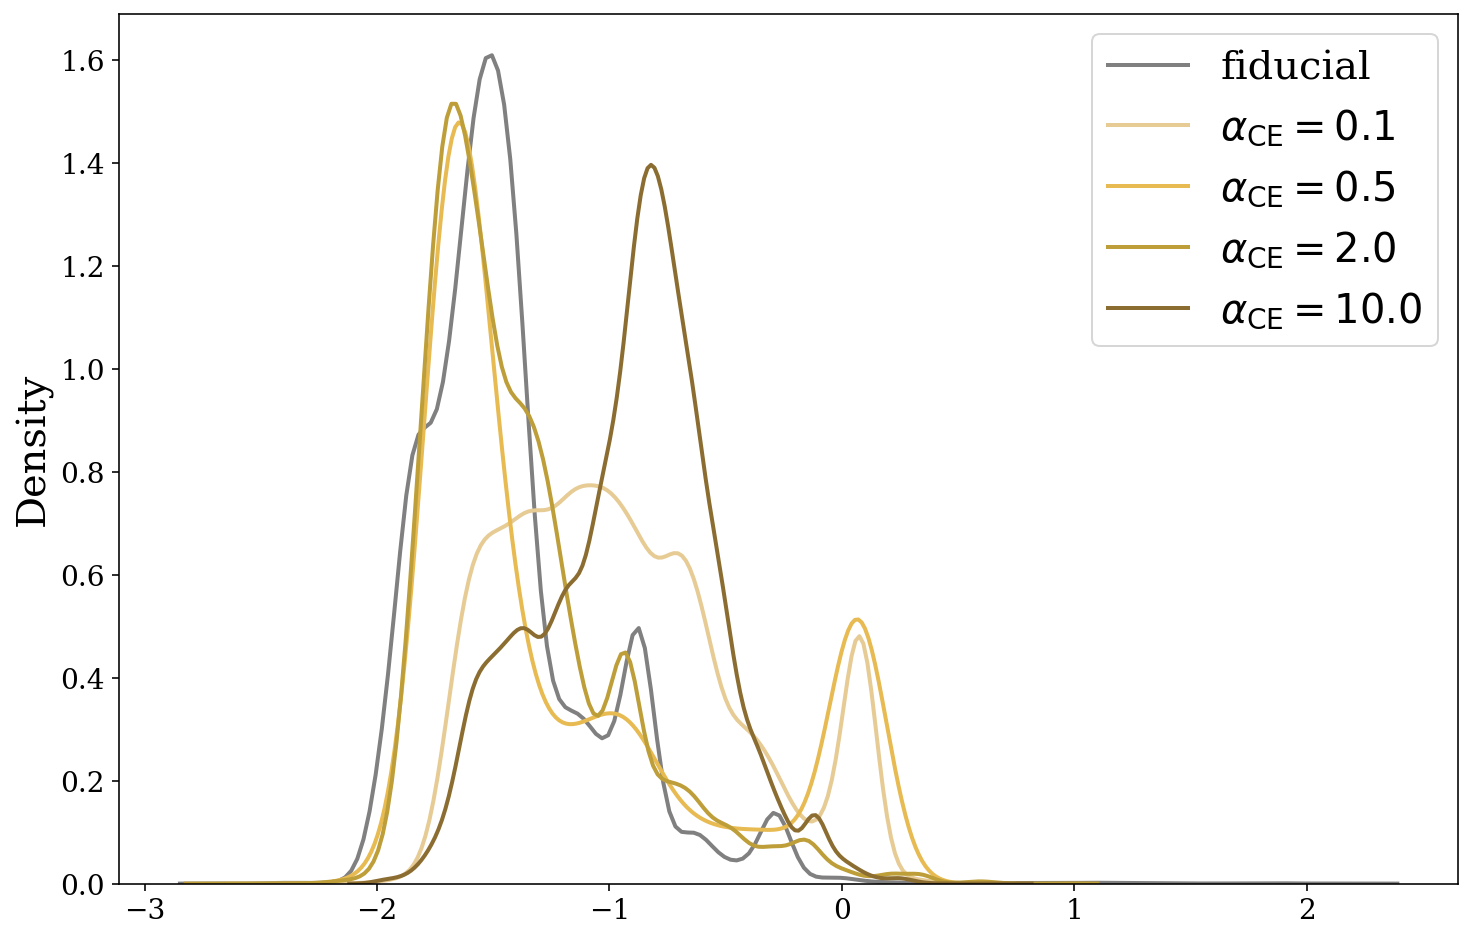

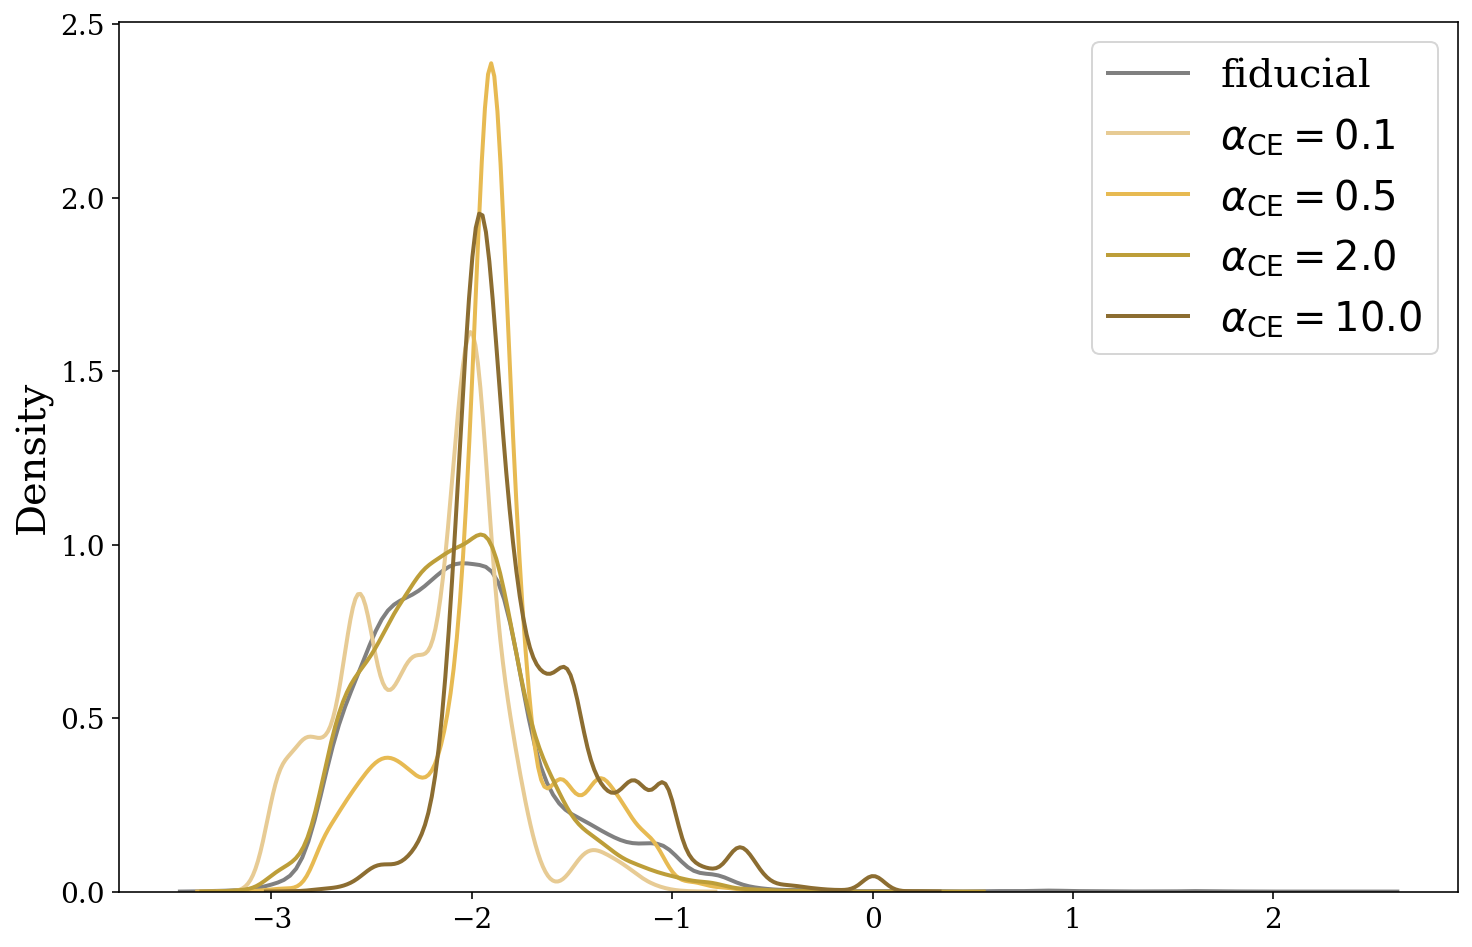

In [15]:
for dco_type in dco_types:

    for v in [0, 6, 7, 8, 9]:

        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[v]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()

        sns.kdeplot(np.log10(data["a_pre_SN2"]), weights=data["weight"], color=variations[v]["colour"],
                    label=variations[v]["med"], lw=2)

    plt.legend()

#     plt.xlim(-2, 1)
    # plt.ylim(1e-2, 1e2)

    plt.show()